In [116]:
import pandas as pd
import math

# TODO: 2016 data, demographic data, output as a map, announce winner, have more "graduate student descent" parameters, more weight/info to/about more recent polls
# Parameter for # of polls in that state/region?
# Graduate student descent with various factors for polls

OVERRIDE_DATE = None #"2024-10-21" # Cut off polls at a specified date: "yyyy-mm-dd" or None for no override
SAVE_MODE = True # Should we save an output file?
SHOW_MARGINS = True # Display vote margins on the map? (False => show electoral vote numbers)

In [117]:
results_2020 = pd.read_csv("results_2020.csv")
# Replace each ME-nTooltip... with ME-n
results_2020["state"] = results_2020["state"].fillna("National")
results_2020["state"] = results_2020["state"].apply(lambda x: x[0:4] if x[2] == "-" else x)
results_2020 = results_2020[["state","Biden%","Trump%","Margin%","BidenEV","TrumpEV"]]

results_2020 = results_2020.rename(columns={"Margin%": "score_difference"})

# Replace every − with -
results_2020["score_difference"] = results_2020["score_difference"].apply(lambda x: x.replace("−", "-"))

# Replace all the percentages with the actual number, in every column
results_2020["Biden%"] = results_2020["Biden%"].apply(lambda x: float(x.strip("%")))
results_2020["Trump%"] = results_2020["Trump%"].apply(lambda x: float(x.strip("%")))
results_2020["score_difference"] = results_2020["score_difference"].apply(lambda x: float(x.strip("%")))

# a dictionary of each state name to a unique integer from 1 to 50
state_dict = {state: i for i, state in enumerate(results_2020["state"], 1)}
# Replace each state name with the corresponding integer
results_2020["state"] = results_2020["state"].apply(lambda x: state_dict[x])

print(state_dict)

# Inverse of state_dict
state_dict_inv = {v: k for k, v in state_dict.items()}

electors_2024 = {
    "Alabama": 9,
    "Alaska": 3,
    "Arizona": 11,
    "Arkansas": 6,
    "California": 54,
    "Colorado": 10,
    "Connecticut": 7,
    "Delaware": 3,
    "Florida": 30,
    "Georgia": 16,
    "Hawaii": 4,
    "Idaho": 4,
    "Illinois": 19,
    "Indiana": 11,
    "Iowa": 6,
    "Kansas": 6,
    "Kentucky": 8,
    "Louisiana": 8,
    "Maine": 2,
    "Maryland": 10,
    "Massachusetts": 11,
    "Michigan": 15,
    "Minnesota": 10,
    "Mississippi": 6,
    "Missouri": 10,
    "Montana": 4,
    "Nebraska": 2,
    "Nevada": 6,
    "New Hampshire": 4,
    "New Jersey": 14,
    "New Mexico": 5,
    "New York": 28,
    "North Carolina": 16,
    "North Dakota": 3,
    "Ohio": 17,
    "Oklahoma": 7,
    "Oregon": 8,
    "Pennsylvania": 19,
    "Rhode Island": 4,
    "South Carolina": 9,
    "South Dakota": 3,
    "Tennessee": 11,
    "Texas": 40,
    "Utah": 6,
    "Vermont": 3,
    "Virginia": 13,
    "Washington": 12,
    "West Virginia": 4,
    "Wisconsin": 10,
    "Wyoming": 3,
    "District of Columbia": 3,
    "ME-1": 1,
    "ME-2": 1,
    "NE-1": 1,
    "NE-2": 1,
    "NE-3": 1
    # Add more states and their corresponding number of electors here
}

swing_states = ["Arizona","Pennsylvania","Nevada","Michigan","Wisconsin","North Carolina","Georgia","Florida","Ohio","Iowa","Minnesota","New Hampshire","New Mexico","Colorado","Virginia","Texas"]
key_states = swing_states[:7]

{'Alabama': 1, 'Alaska': 2, 'Arizona': 3, 'Arkansas': 4, 'California': 5, 'Colorado': 6, 'Connecticut': 7, 'Delaware': 8, 'District of Columbia': 9, 'Florida': 10, 'Georgia': 11, 'Hawaii': 12, 'Idaho': 13, 'Illinois': 14, 'Indiana': 15, 'Iowa': 16, 'Kansas': 17, 'Kentucky': 18, 'Louisiana': 19, 'Maine': 20, 'ME-1': 21, 'ME-2': 22, 'Maryland': 23, 'Massachusetts': 24, 'Michigan': 25, 'Minnesota': 26, 'Mississippi': 27, 'Missouri': 28, 'Montana': 29, 'Nebraska': 30, 'NE-1': 31, 'NE-2': 32, 'NE-3': 33, 'Nevada': 34, 'New Hampshire': 35, 'New Jersey': 36, 'New Mexico': 37, 'New York': 38, 'North Carolina': 39, 'North Dakota': 40, 'Ohio': 41, 'Oklahoma': 42, 'Oregon': 43, 'Pennsylvania': 44, 'Rhode Island': 45, 'South Carolina': 46, 'South Dakota': 47, 'Tennessee': 48, 'Texas': 49, 'Utah': 50, 'Vermont': 51, 'Virginia': 52, 'Washington': 53, 'West Virginia': 54, 'Wisconsin': 55, 'Wyoming': 56, 'National': 57}


In [118]:
def getShortenedDistrictName(district):
    if district == "Maine CD-1":
        return "ME-1"
    elif district == "Maine CD-2":
        return "ME-2"
    elif district == "Nebraska CD-1":
        return "NE-1"
    elif district == "Nebraska CD-2":
        return "NE-2"
    elif district == "Nebraska CD-3":
        return "NE-3"
    else:
        return district

#current_polls = pd.read_csv("president_polls.csv")
current_polls = pd.read_csv("https://projects.fivethirtyeight.com/polls-page/data/president_polls.csv")

# Get the columns of current_polls that I choose
current_polls = current_polls[["poll_id","state", "numeric_grade", "sample_size", "population", "end_date", "candidate_name", "pct"]]

# in the "population" column, replace "lv" with 3, "rv" with 2, "a" with 1 and anything else with 1.5, all at once:
current_polls["population"] = current_polls["population"].fillna(0)
current_polls["population"] = current_polls["population"].replace({"lv":3, "rv":2, "a":1, "v":0})

# in the "numeric_grade" column, replace NaN with 1.0
current_polls["numeric_grade"] = current_polls["numeric_grade"].fillna(1.5)

# in the "state" column, replace NaN with "National"
current_polls["state"] = current_polls["state"].fillna("National")

current_polls["state"] = current_polls["state"].apply(lambda x: getShortenedDistrictName(x))

# replace the state names with the integers in the dictionary
current_polls["state"] = current_polls["state"].replace(state_dict)

# Replace each sample size with the log base 10 of the sample size
# First, replace NaN with 400
current_polls["sample_size"] = current_polls["sample_size"].fillna(400)
current_polls["sample_size"] = current_polls["sample_size"].apply(lambda x: 0 if x == 0 else math.log10(x))

# Replace end_date with the number of days between end_date and November 5, 2024
current_polls["end_date"] = (pd.to_datetime("11/5/24") - pd.to_datetime(current_polls["end_date"])).dt.days

# Rename end_date to days_until_election
current_polls = current_polls.rename(columns={"end_date": "days_until_election"})

# Remove any row with a candidate that isn't Kamala Harris or Donald Trump
current_polls = current_polls[(current_polls["candidate_name"] == "Kamala Harris") | (current_polls["candidate_name"] == "Donald Trump")]

# Replace the candidate names with 1 for Kamala Harris and 0 for Donald Trump
current_polls["candidate_name"] = current_polls["candidate_name"].replace({"Kamala Harris": 1, "Donald Trump": 0})

# Remove any polls more than 100 days from the election
current_polls = current_polls[current_polls["days_until_election"] <= 100]

if OVERRIDE_DATE != None:
    current_polls = current_polls[current_polls["days_until_election"] >= (pd.to_datetime("11/5/24") - pd.to_datetime(OVERRIDE_DATE)).days]

# Group the current_polls dataframe by poll_id and state, and calculate the difference in score between Kamala Harris and Donald Trump
consolidated_polls = current_polls.groupby(['poll_id', 'state']).agg({'pct': lambda x: x.iloc[0] - x.iloc[1]}).reset_index()

# Rename the column to represent the difference in score
consolidated_polls = consolidated_polls.rename(columns={'pct': 'score_difference'})

# Merge the consolidated_polls dataframe with the current_polls dataframe to include the score difference
current_polls = current_polls.merge(consolidated_polls, on=['poll_id', 'state'])

print(current_polls)

      poll_id  state  numeric_grade  sample_size  population  \
0       89289     57            1.1     3.047275           2   
1       89289     57            1.1     3.047275           2   
2       89290     44            1.1     2.955688           2   
3       89290     44            1.1     2.955688           2   
4       89291     25            1.1     2.933487           2   
...       ...    ...            ...          ...         ...   
4222    87650     41            1.7     2.778151           3   
4223    87650     41            1.7     2.778151           3   
4224    87650     41            1.7     2.778151           3   
4225    87618     44            2.3     2.778151           3   
4226    87618     44            2.3     2.778151           3   

      days_until_election  candidate_name   pct  score_difference  
0                       2               1  49.4               1.3  
1                       2               0  48.1               1.3  
2                       2  

C:\Users\ehric\AppData\Local\Temp\ipykernel_51060\5294059.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  current_polls["end_date"] = (pd.to_datetime("11/5/24") - pd.to_datetime(current_polls["end_date"])).dt.days


In [119]:
#historical_polls = pd.read_csv("president_polls_historical.csv")

historical_polls = pd.read_csv("https://projects.fivethirtyeight.com/polls-page/data/president_polls_historical.csv")

# Get the columns of historical_polls that I choose
historical_polls = historical_polls[["poll_id","state", "numeric_grade", "sample_size", "population", "end_date", "answer", "pct"]]

# do all the same modifications as we did to current_polls, to historical_polls

historical_polls["numeric_grade"] = historical_polls["numeric_grade"].fillna(0)
historical_polls["population"] = historical_polls["population"].replace({"lv":3, "rv":2, "a":1, "v":0})
historical_polls["numeric_grade"] = historical_polls["numeric_grade"].fillna(1.5)
historical_polls["state"] = historical_polls["state"].fillna("National")
historical_polls["state"] = historical_polls["state"].replace(state_dict)
historical_polls["sample_size"] = historical_polls["sample_size"].fillna(400)
historical_polls["sample_size"] = historical_polls["sample_size"].apply(lambda x: 0 if x == 0 else math.log10(x))
historical_polls["end_date"] = (pd.to_datetime("11/3/20") - pd.to_datetime(historical_polls["end_date"])).dt.days
historical_polls = historical_polls.rename(columns={"end_date": "days_until_election"})
historical_polls = historical_polls[(historical_polls["answer"] == "Biden") | (historical_polls["answer"] == "Trump")]
historical_polls["answer"] = historical_polls["answer"].replace({"Biden": 1, "Trump": 0})
historical_polls = historical_polls[historical_polls["days_until_election"] <= 100]

# Group the historical_polls dataframe by poll_id and state, and calculate the difference in score between Biden and Trump
consolidated_polls = historical_polls.groupby(['poll_id', 'state']).agg({'pct': lambda x: x.iloc[0] - x.iloc[1]}).reset_index()

# Rename the column to represent the difference in score
consolidated_polls = consolidated_polls.rename(columns={'pct': 'score_difference'})

# Merge the consolidated_polls dataframe with the current_polls dataframe to include the score difference
historical_polls = historical_polls.merge(consolidated_polls, on=['poll_id', 'state'])

print(historical_polls)

      poll_id state  numeric_grade  sample_size  population  \
0       73830    57            1.2     3.380211           3   
1       73830    57            1.2     3.380211           3   
2       74946    10            0.7     2.984977           3   
3       74946    10            0.7     2.984977           3   
4       72621    16            1.4     2.940018           0   
...       ...   ...            ...          ...         ...   
9423    67694    49            1.9     3.428944           3   
9424    67695    52            1.9     3.062958           3   
9425    67695    52            1.9     3.062958           3   
9426    67696    55            1.9     2.907949           3   
9427    67696    55            1.9     2.907949           3   

      days_until_election  answer   pct  score_difference  
0                       0       1  51.0               3.0  
1                       0       0  48.0               3.0  
2                       1       1  44.2              -3.8  
3  

C:\Users\ehric\AppData\Local\Temp\ipykernel_51060\1924028020.py:3: DtypeWarning: Columns (16,17,26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  historical_polls = pd.read_csv("https://projects.fivethirtyeight.com/polls-page/data/president_polls_historical.csv")
C:\Users\ehric\AppData\Local\Temp\ipykernel_51060\1924028020.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  historical_polls["end_date"] = (pd.to_datetime("11/3/20") - pd.to_datetime(historical_polls["end_date"])).dt.days


In [120]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# get the linear classifier
from sklearn.linear_model import LinearRegression

In [121]:
# Blank PD dataframe with a columns for each of 22 summary statistics

def getDataFrame(poll_set):
    X_train = pd.DataFrame(columns=["avg_score_difference", "std_score_difference"] + ["avg_score_difference_"+str(i) for i in range(10)] + ["std_score_difference_"+str(i) for i in range(10)])
    
    for state in state_dict.values():
        this_state = poll_set[poll_set["state"] == state].sort_values(by='days_until_election', ascending=True)

        summary_stats = {
            "avg_score_difference": this_state["score_difference"].mean(),
            #"std_score_difference": this_state["score_difference"].std(),
        }

        election_week_polls = this_state[this_state['days_until_election'] <= 7]
        summary_stats["election_week"] = election_week_polls["score_difference"].mean()

        for i in range(10):
            recent_polls = this_state[this_state['days_until_election'] < 12*(max(i,2.5)+1)]
            recent_polls = this_state[int(len(this_state)/10*(i)) : int(len(this_state)/10*(i+1))]
            average_score_difference = recent_polls['score_difference'].mean()
            #std_score_difference = recent_polls['score_difference'].std()
            summary_stats['avg_score_difference_'+str(i)] = average_score_difference
            #summary_stats['std_score_difference_'+str(i)] = std_score_difference
        
        state_name = state_dict_inv[state]

        total_polls = len(this_state)
        #summary_stats["total_polls"] = total_polls
        #print(state_name,total_polls)

        # summary_stats["election_week"] = this_state["score_difference"].tail(4).mean()
        # summary_stats["avg_set_2"] = this_state["score_difference"].tail(8).mean()
        # summary_stats["avg_set_3"] = this_state["score_difference"].tail(12).mean()

        #summary_stats["stddev_last_25"] = this_state["score_difference"].tail(25).std()
        #summary_stats["stddev_last_100"] = this_state["score_difference"].tail(100).std()

        if state_name == "Florida":
            print(state,state_dict_inv[state])
            print(summary_stats)

        X_train.loc[state] = summary_stats

        # Replace NaN values in X_train with overall average
        if average_score_difference:
            X_train = X_train.fillna(average_score_difference)
    
    return X_train


X_train = getDataFrame(historical_polls)
X_train_0 = X_train.dropna()

X_test = getDataFrame(current_polls)

10 Florida
{'avg_score_difference': 2.184047619047619, 'election_week': 2.041176470588235, 'avg_score_difference_0': 1.9030303030303028, 'avg_score_difference_1': 2.2823529411764705, 'avg_score_difference_2': 1.8727272727272726, 'avg_score_difference_3': 0.7635294117647052, 'avg_score_difference_4': 1.843529411764706, 'avg_score_difference_5': 2.1939393939393943, 'avg_score_difference_6': 3.935294117647059, 'avg_score_difference_7': 2.9248484848484857, 'avg_score_difference_8': 2.132941176470588, 'avg_score_difference_9': 1.992941176470588}
10 Florida
{'avg_score_difference': -5.84709090909091, 'election_week': -5.899999999999999, 'avg_score_difference_0': -7.3999999999999995, 'avg_score_difference_1': -5.3999999999999995, 'avg_score_difference_2': -7.163636363636365, 'avg_score_difference_3': -5.363636363636363, 'avg_score_difference_4': -10.727272727272727, 'avg_score_difference_5': -4.909090909090909, 'avg_score_difference_6': -3.4036363636363647, 'avg_score_difference_7': -4.976363

In [122]:
# Get the target values
y_train_0 = results_2020["score_difference"]

# Get the states with at least 20 polls in current_polls
states_with_20_polls = current_polls["state"].value_counts()[current_polls["state"].value_counts() >= 20].index

print(states_with_20_polls)
    
print(len(states_with_20_polls))

# Filter X_train, X_test, y_train, y_test based on states_with_20_polls
X_train_0 = X_train_0.loc[states_with_20_polls]

y_train_0 = y_train_0.loc[[i-1 for i in states_with_20_polls]]

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X_train_0, y_train_0, test_size=0.2, random_state=100)

# Create the linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train_0, y_train_0)

# Get the predictions
# Set X_test based on current_polls

predictions = model.predict(X_test)

# Print a list of state names from X_test
states = list(X_test.index)

paired_results = {}
colored_results = {}

electoral_results = {"Harris":0,"Trump":0,"Tossup":0}

for i,state in enumerate(states):
    state_vote_result = results_2020[results_2020["state"] == state]["score_difference"].values[0]
    error = abs(predictions[i] - state_vote_result)

    outcome = -predictions[i] if abs(error) <= 10 else -state_vote_result
    predictions[i] = -outcome
    error = abs(predictions[i] - state_vote_result)

    #print(f"{state_dict_inv[state]}: {predictions[i]:.2f}% (delta: {error:.2f}%)")

    color_code = 0
    if abs(outcome) < 1.0:
        color_code = 0
    elif abs(outcome) < 3.0:
        color_code = abs(outcome)/outcome * 5
    elif abs(outcome) < 5.0:
        color_code = abs(outcome)/outcome * 10
    elif abs(outcome) < 10.0:
        color_code = abs(outcome)/outcome * 15
    else:
        color_code = abs(outcome)/outcome * 20

    paired_results[state_dict_inv[state]] = predictions[i]
    colored_results[state_dict_inv[state]] = color_code

    if state != 57:
        electors = electors_2024[state_dict_inv[state]]
        if abs(outcome) < 1.0:
            electoral_results["Tossup"] += electors
        elif outcome < 0:
            electoral_results["Harris"] += electors
        else:
            electoral_results["Trump"] += electors

rounded_results = {state:round(paired_results[state],2) for state in paired_results}

# Sort rounded_results by margin
def format_result(result):
    if result < 0:
        return "R+"+str(abs(result))
    else:
        return "D+"+str(abs(result))
rounded_results = dict(sorted(rounded_results.items(), key=lambda item: abs(item[1])))
for i,v in rounded_results.items():
    rounded_results[i] = format_result(v)

Index([57, 44, 25, 55, 39,  3, 11, 34, 10, 49, 41, 52, 26,  5, 23, 35, 30, 38,
       29, 32, 37, 24, 50],
      dtype='int64', name='state')
23


# Plot the Results on a Graphic Map

c:\Users\ehric\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


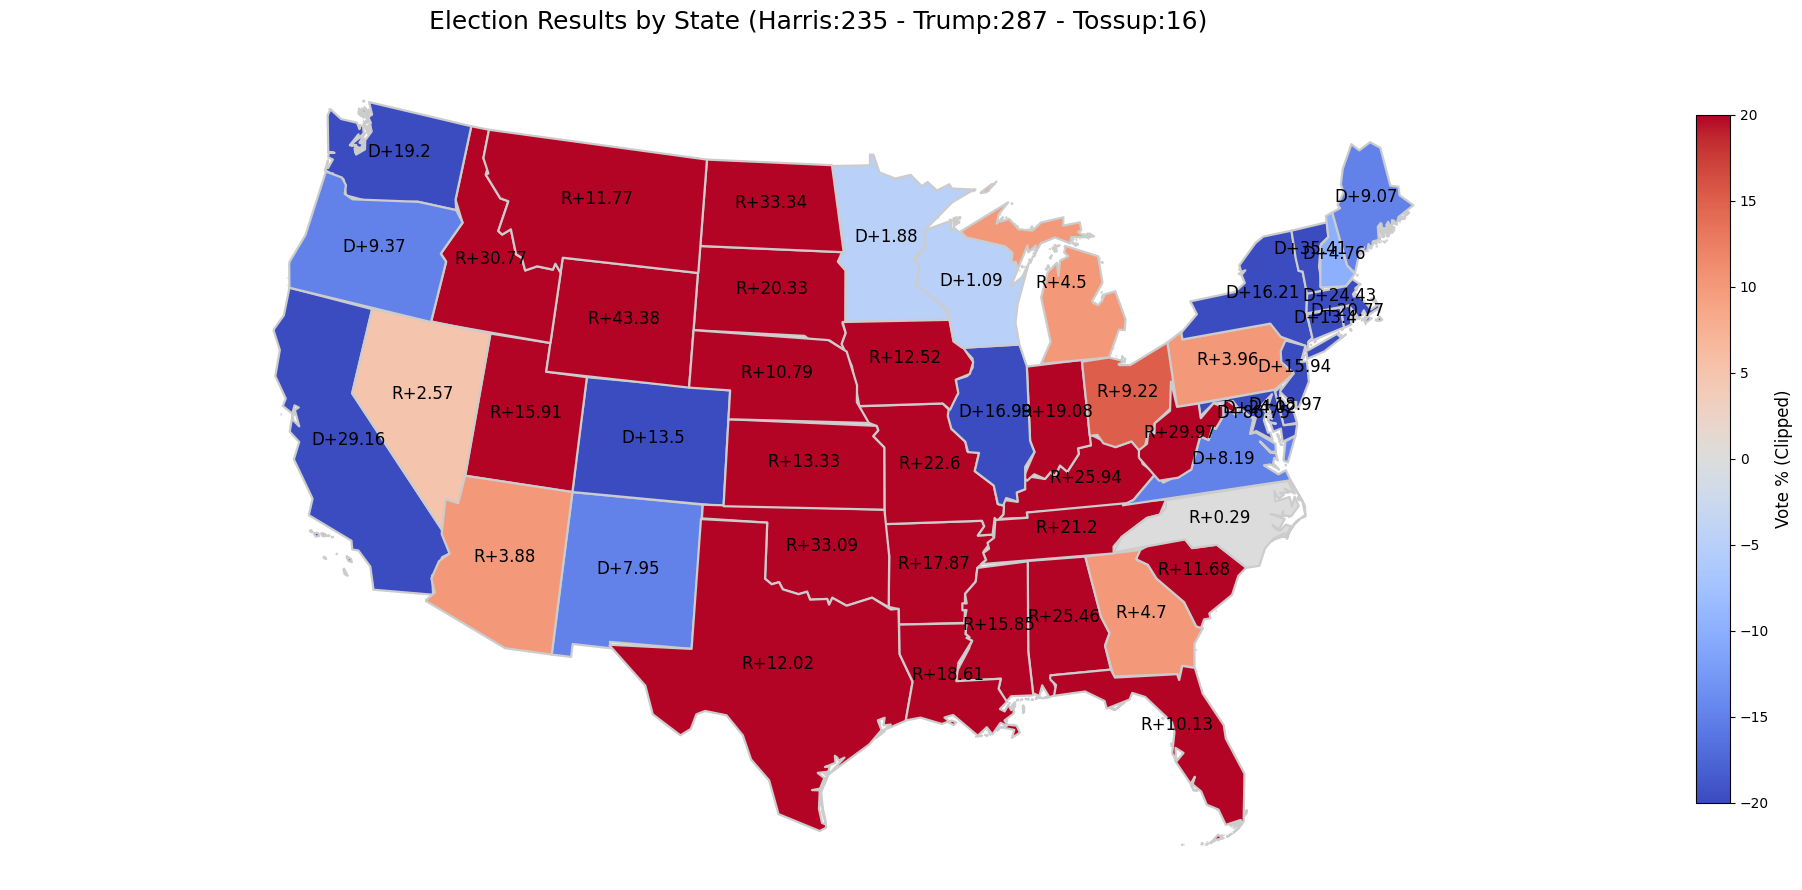

In [123]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import datetime
import os
import json

us_states = gpd.read_file("maps/cb_2023_us_state_500k.shp")

us_states["margin"] = us_states["NAME"].map(colored_results)

# Assuming `us_states` is your GeoDataFrame and 'vote_percentage' is the column with data
# Clip the vote percentage values to the range -15 to 15
us_states['margin'] = np.clip(us_states['margin'], -20, 20)

us_states['geometry'] = us_states.geometry.simplify(tolerance=0.125)

# Set up the plot with a taller figure size
#fig, ax = plt.subplots(1, 1, figsize=(20, 20))  # Make the figure taller by increasing the height

fig = plt.figure(figsize=(20, 30))  # Make the figure taller
#fig, ax = plt.subplots(2, 1, figsize=(20, 30), gridspec_kw={'height_ratios': [3, 1]})
ax = fig.add_subplot(1, 1, 1, projection=ccrs.AlbersEqualArea(central_longitude=-96, central_latitude=37))

us_states.to_crs({'init':'epsg:3857'})

# Plot the map with the color scale ranging from -15 to 15
# Capture the returned plot to add a colorbar later
plot = us_states.plot(
    column='margin',
    cmap='coolwarm',
    linewidth=1.6,
    ax=ax,
    edgecolor='0.8',
    legend=False,  # Disable the default legend
    vmin=-20,  # Set the minimum value for the color scale
    vmax=20,    # Set the maximum value for the color scale
    transform=ccrs.PlateCarree()
)

# Manually create a colorbar
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=-20, vmax=20))
sm._A = []  # Empty array for the scalar mappable
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Vote % (Clipped)', fontsize=12)

# Adjust the aspect ratio of the map
ax.set_aspect('equal')  # Use 'equal' to maintain the aspect ratio of the map

# Manually set the plot area to fill more of the figure
ax.set_position([0.05, 0.05, 0.9, 0.9])  # [left, bottom, width, height]

ax.set_xlim([-130, -65])  # Longitude limits for contiguous US
ax.set_ylim([24, 50])     # Latitude limits for contiguous US

ax.set_extent([-130, -65, 24, 50], crs=ccrs.PlateCarree())

for idx, row in us_states.iterrows():
    # Get the centroid of the state's geometry
    centroid = row['geometry'].centroid
    state_name = row['NAME']  # Assuming you have a column 'name' for state names
    if state_name == "Alaska" or state_name == "Hawaii" or state_name not in state_dict_inv.values():
        continue
    # Get the number of electors for the state
    electors = electors_2024.get(state_name, 0)  # Default to 0 if state not found
    # Annotate the centroid with the number of electors
    state_label = None
    font_size = None
    if SHOW_MARGINS:
        state_label = rounded_results[state_name]
        font_size = 12
    else:
        state_label = str(electors if electors>2 else (4 if state_name == "Maine" else 5))
        font_size = 16
    ax.annotate(state_label, 
                xy=(centroid.x, centroid.y), 
                fontsize=font_size, 
                ha='center', 
                transform=ccrs.PlateCarree()
                )

# Customize the plot
ax.set_title(f'Election Results by State (Harris:{electoral_results["Harris"]} - Trump:{electoral_results["Trump"]} - Tossup:{electoral_results["Tossup"]})', fontdict={'fontsize': '18', 'fontweight': '3'})
ax.set_axis_off()

proportions = electoral_results

labels = proportions.keys()
bar_width = 0.4  # Width of the bars
y_positions = np.arange(len(labels))  # Position of the bars

# Show the plot with the taller aspect ratio
plt.tight_layout()

current_datetime = datetime.datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")
filename = f"outputs/result_{formatted_datetime}/"

if OVERRIDE_DATE != None:
    filename = f"outputs/override_{OVERRIDE_DATE}/"

# Create output directory
if SAVE_MODE:
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    plt.savefig(filename+"map.png", dpi=300, bbox_inches='tight')

plt.show()

# Save JSON file with results

if SAVE_MODE:
    with open(filename+"results.json", "w") as f:
        output_dict = {
            "time": {
                "year": 2024,
                "month": current_datetime.month,
                "day": current_datetime.day,
                "hour": current_datetime.hour,
                "minute": current_datetime.minute,
                "second": current_datetime.second,
                "epoch": current_datetime.timestamp(),
            },
            "electoral_votes":
                {
                    "Harris": electoral_results["Harris"],
                    "Trump": electoral_results["Trump"],
                    "Tossup": electoral_results["Tossup"],
                },
            "state_results": paired_results,
        }
        json.dump(output_dict, f)


### Print out the state-by-state margins & results, numerically

In [124]:
print("All States:",rounded_results)
#print("Swing States:", {state:rounded_results[state] for state in rounded_results if state in swing_states})
#print("Key States", {state:rounded_results[state] for state in key_states})

All States: {'North Carolina': 'R+0.29', 'Wisconsin': 'D+1.09', 'National': 'R+1.53', 'Minnesota': 'D+1.88', 'Nevada': 'R+2.57', 'NE-2': 'R+3.23', 'Arizona': 'R+3.88', 'Pennsylvania': 'R+3.96', 'Michigan': 'R+4.5', 'Georgia': 'R+4.7', 'New Hampshire': 'D+4.76', 'ME-2': 'R+7.44', 'New Mexico': 'D+7.95', 'Virginia': 'D+8.19', 'Maine': 'D+9.07', 'Ohio': 'R+9.22', 'Oregon': 'D+9.37', 'Florida': 'R+10.13', 'Nebraska': 'R+10.79', 'NE-1': 'R+10.81', 'South Carolina': 'R+11.68', 'Montana': 'R+11.77', 'Texas': 'R+12.02', 'Iowa': 'R+12.52', 'Kansas': 'R+13.33', 'Connecticut': 'D+13.4', 'Colorado': 'D+13.5', 'Alaska': 'R+15.62', 'Mississippi': 'R+15.85', 'Utah': 'R+15.91', 'New Jersey': 'D+15.94', 'New York': 'D+16.21', 'Illinois': 'D+16.99', 'Arkansas': 'R+17.87', 'Louisiana': 'R+18.61', 'Delaware': 'D+18.97', 'Indiana': 'R+19.08', 'Washington': 'D+19.2', 'South Dakota': 'R+20.33', 'Rhode Island': 'D+20.77', 'Tennessee': 'R+21.2', 'Missouri': 'R+22.6', 'ME-1': 'D+23.09', 'Maryland': 'D+24.02', '

# WIP: Mapping Other Features

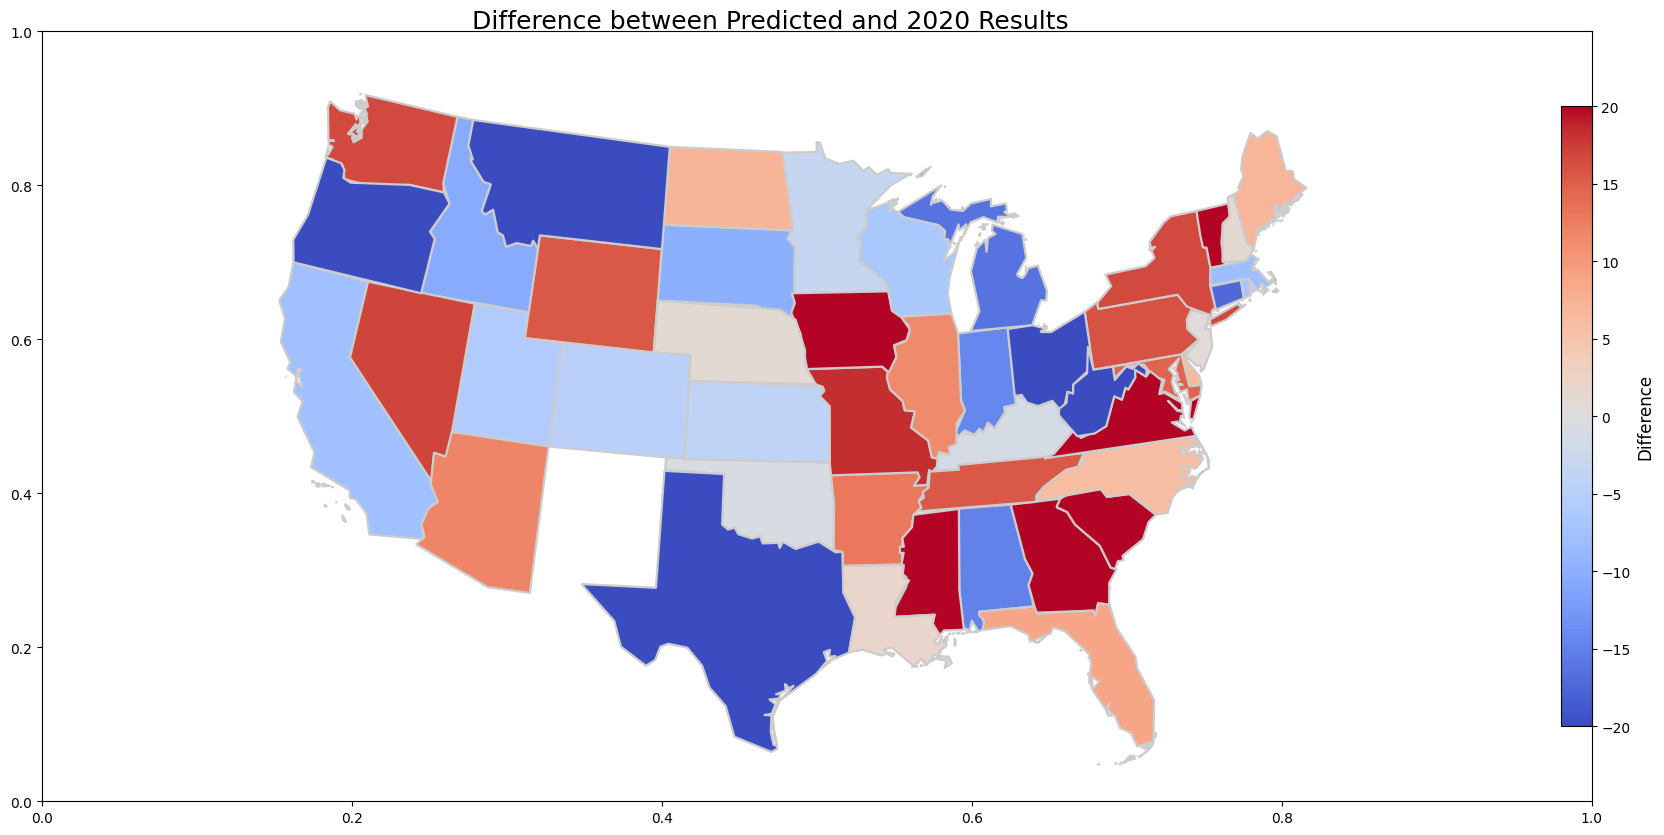

In [125]:
## Map the difference between predicted score and 2020 results
#difference = predictions - results_2020["score_difference"]
#print(difference)

#set difference = avg poll result in each state, as a Pandas column
difference = X_test["avg_score_difference"]

# Map the difference between predicted score and 2020 results
us_states['difference'] = difference

# Clip the difference values to the range -20 to 20
us_states['difference'] = np.clip(us_states['difference'], -20, 20)

# Set up the plot
fig, ax = plt.subplots(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.AlbersEqualArea(central_longitude=-96, central_latitude=37))

ax.set_position([0.05, 0.05, 0.9, 0.9])  # [left, bottom, width, height]

ax.set_xlim([-130, -65])  # Longitude limits for contiguous US
ax.set_ylim([24, 50])     # Latitude limits for contiguous US

ax.set_extent([-130, -65, 24, 50], crs=ccrs.PlateCarree())

# Plot the map with the color scale ranging from -20 to 20
plot = us_states.plot(column='difference', cmap='coolwarm', linewidth=1.6, ax=ax, edgecolor='0.8', legend=False, vmin=-20, vmax=20, transform=ccrs.PlateCarree())

# Manually create a colorbar
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=-20, vmax=20))
sm._A = []  # Empty array for the scalar mappable
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Difference', fontsize=12)

# Customize the plot
ax.set_title('Difference between Predicted and 2020 Results', fontdict={'fontsize': '18', 'fontweight': '3'})
ax.set_axis_off()

# Adjust the aspect ratio of the map
ax.set_aspect('equal')

# Show the plot
plt.show()